# Preparation

In [45]:
# files
import os
import zipfile

# sklearn
from sklearn.model_selection import train_test_split

# images
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn_image as isns
import skimage.exposure

# numpy
import numpy as np
from numpy.random import default_rng
import random

In [32]:
# utility.py functions
from utility import crop, rotate_image, resize, brightness_contrast, split_patches

#### Functions

In [33]:
# Function to apply a set of preprocessing functions and saving them divided in train and test sets
def preprocess(source_path, dest_path, functions=[], format='.jpg', augment=False, test_size_ok=0, test_size_nok=0, seed=0):
    
    for folder in os.listdir(source_path):
        list_imgs = os.listdir(source_path + '/' + folder)
        if folder == 'OK':
            train_imgs, test_imgs = train_test_split(list_imgs, test_size=test_size_ok, random_state=seed)
            i=0
            for img_name in train_imgs:
                img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
                for func in functions:
                    img = func(img) 
                j=0
                for slice in img:
                    new_path = dest_path + '/Train/' + folder + '/' + folder + '_' + str(i) + '-' + str(j) + format
                    cv.imwrite(new_path, slice)
                    j=j+1
                i=i+1

                # Data augmentation: random rotate (-4°, 4°), random brightness and contrast adjusts 
                if augment:
                    img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
                    random.seed(i)
                    img = brightness_contrast(img, random.randrange(-50, 50, 5), random.randrange(-50, 50, 5))
                    img = rotate_image(img, random.randrange(-4, 4, 1))
                    for func in functions:
                        img = func(img) 
                    j=0
                    for slice in img:
                        new_path = dest_path + '/Train/' + folder + '/' + folder + '_' + str(i) + '-' + str(j) + '-aug' + format
                        cv.imwrite(new_path, slice)
                        j=j+1
                    i=i+1
            i=0
            for img_name in test_imgs:
                img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
                new_path = dest_path + '/Test/' + folder + '/' + folder + '_' + str(i) + format
                cv.imwrite(new_path, img)
                i=i+1
        else:
            train_imgs, test_imgs = train_test_split(list_imgs, test_size=test_size_nok, random_state=seed)
            i=0
            for img_name in train_imgs:
                img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
                new_path = dest_path + '/Train/' + folder + '/' + folder + '_' + str(i) + format
                cv.imwrite(new_path, img)
                i=i+1
            i=0
            for img_name in test_imgs:
                img = cv.imread(source_path + '/' + folder + '/' + img_name, cv.IMREAD_GRAYSCALE)
                new_path = dest_path + '/Test/' + folder + '/' + folder + '_' + str(i) + format
                cv.imwrite(new_path, img)
                i=i+1

        

In [34]:
# Function to create a noisy dataset
def noisy_dataset(source_path, dest_path):
    seed=0
    for img_name in os.listdir(source_path):
        image = cv.imread(source_path + '/' + img_name, cv.IMREAD_GRAYSCALE)
        noisy_img = add_noise(image, seed)
        cv.imwrite(dest_path + '/noisyOK/' + img_name, noisy_img)
        seed=seed+1

In [35]:
# Function to add random noise to image, to simulate defects
def add_noise(img, seed=0):
    height, width = img.shape[:2]

    # define random seed to change the pattern
    rng = default_rng(seed=seed)

    # create random noise image
    noise = rng.integers(0, 255, (height,width), np.uint8, True)

    # blur the noise image to control the size
    blur = cv.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv.BORDER_DEFAULT)

    # stretch the blurred image to full dynamic range
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

    # threshold stretched image to control the size
    thresh = cv.threshold(stretch, 220, 255, cv.THRESH_BINARY)[1]

    # apply morphology open and close to smooth out
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))
    mask = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # add mask to input
    noisy_img = cv.add(img, mask)
    random.seed(seed)
    noisy_img[np.where((mask == [255]))] = [random.randrange(0, 50, 1,)]

    return noisy_img

## Dataset extraction

In [36]:
zipf = zipfile.ZipFile('../Data/DatasetGP5Bicocca.zip')
zipf.extractall("../Data")
zipf.close()

## Data exploration and visualization

In [37]:
path_data = '../Data/DatasetGP5Bicocca'

#### Number of images for each class

In [38]:
list_NOK = os.listdir(path_data + '/NOK')
list_OK = os.listdir(path_data + '/OK')
number_NOK = len(list_NOK)
number_OK = len(list_OK)
print("The number of NO ok images is:", number_NOK)
print("The number of ok images is:", number_OK)

The number of NO ok images is: 19
The number of ok images is: 104


#### Example of OK and NOK images

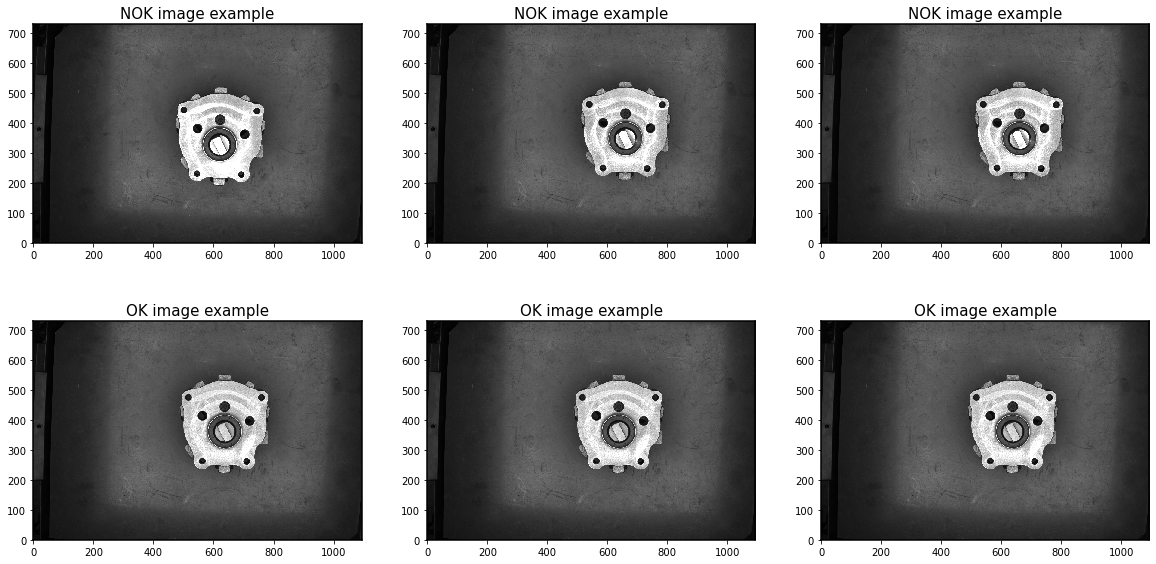

In [39]:
# Plotting the first 3 images for the classes OK and NOK
plt.figure(figsize=(20,10))
i=1
for folder in os.listdir(path_data):
    for img, j in zip(os.listdir(path_data + '/' + folder), range(0, 3)):
        example = cv.imread(path_data + '/' + folder + '/' + img, cv.IMREAD_GRAYSCALE)
        example = cv.resize(example, (None), fx=0.2, fy=0.2)
        plt.subplot(2,3,i)
        plt.title(folder +  ' image example')
        plt.imshow(cv.flip(example, flipCode=0), cmap='gray')
        i=i+1

Da queste immagini si può notare come la caratteristica principale delle immagini NOK è quella di presentare delle piccole macchie nere sulla superficie del pezzo (dovuto alla mancanza di materiale).
Si osserva che le dimensioni dei difetti sono molto ridotte e questo fatto dovrà essere tenuto in considerazione nella fase di selezione del modello.

### Histogram images comparison

Text(0.5, 1.0, 'Defective piece')

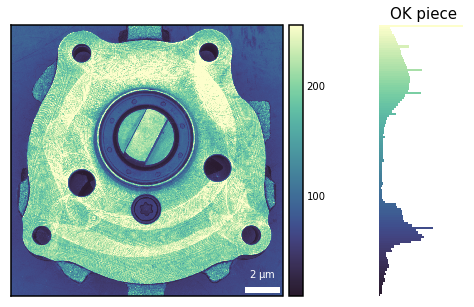

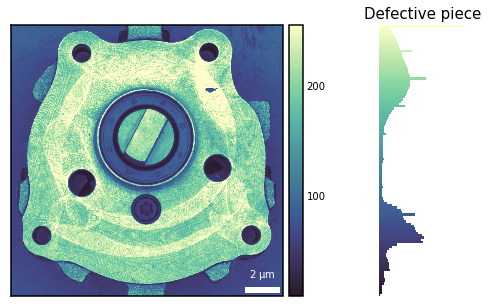

In [40]:
example_ok = cv.imread(path_data + '/OK/OK (2).bmp', cv.IMREAD_GRAYSCALE)
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp', cv.IMREAD_GRAYSCALE)

example_crop_ok = crop(example_ok)
example_crop_nok = crop(example_nok)

isns.imghist(example_crop_ok, dx=0.01, units="um")
plt.title('OK piece')

isns.imghist(example_crop_nok, dx=0.01, units="um")
plt.title('Defective piece')

Non si riscontrano varianze significative negli istogrammi per via della dimensione ridotta dei difetti

## Cleaning

#### Crop production piece from image

Text(0.5, 1.0, 'Threshold mask')

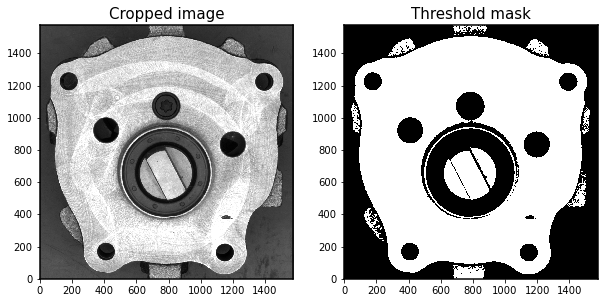

In [41]:
#example of crop function
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(crop(cv.flip(example_nok, flipCode=0)), cmap='gray')
plt.title('Cropped image')

plt.subplot(1, 2, 2)
plt.imshow(crop(cv.flip(example_nok, flipCode=0), True), cmap='gray')
plt.title('Threshold mask')


## Save prepared dataset and add noise

In [42]:
preprocess(path_data, dest_path='../Data/Prepared', functions=[crop, resize, split_patches], format='.jpg', augment=True, test_size_ok=0.1, test_size_nok=0.8, seed=17)

In [43]:
noisy_dataset('../Data/Prepared/Train/OK', dest_path='../Data/Prepared/Train')